In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist

In [11]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize the images to [0,1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

In [12]:
# Define a simple feedforward neural network
model = Sequential([
Flatten(input_shape=(28, 28)), # Flatten the 28x28 image into a vector
Dense(128, activation='relu'), # Hidden layer with ReLU activation
Dense(10, activation='softmax') # Output layer for 10 classes
])
# Compile the model
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
# Train the model
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5


2025-02-03 03:26:02.002642: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8812 - loss: 0.4226 

2025-02-03 03:26:27.509132: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.8813 - loss: 0.4224 - val_accuracy: 0.9584 - val_loss: 0.1363
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9644 - loss: 0.1199 - val_accuracy: 0.9719 - val_loss: 0.0909
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9777 - loss: 0.0764 - val_accuracy: 0.9742 - val_loss: 0.0833
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9836 - loss: 0.0531 - val_accuracy: 0.9780 - val_loss: 0.0718
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9871 - loss: 0.0421 - val_accuracy: 0.9767 - val_loss: 0.0763


In [13]:
# Evaluate on clean test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy on Clean Data: {test_acc * 100:.2f}%")

2025-02-03 03:28:25.603732: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 - 2s - 6ms/step - accuracy: 0.9767 - loss: 0.0763
Test Accuracy on Clean Data: 97.67%


In [14]:
# Convert the model into a TensorFlow function for gradient calculation
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_example(model, image, label, epsilon=0.1):
    image = tf.convert_to_tensor(image.reshape((1, 28, 28)))
    label = tf.convert_to_tensor([label])
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_object(label, prediction)
    # Compute the gradient of the loss w.r.t the input image
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    # Generate the adversarial example
    adversarial_image = image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    # Keep pixel values valid
    return adversarial_image.numpy().reshape(28, 28)
# Select a sample image from test set
idx = 0 # Choose the first image
original_image = x_test[idx]
original_label = y_test[idx]
# Generate adversarial example
epsilon = 0.1
adversarial_image = create_adversarial_example(model, original_image, original_label, epsilon)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


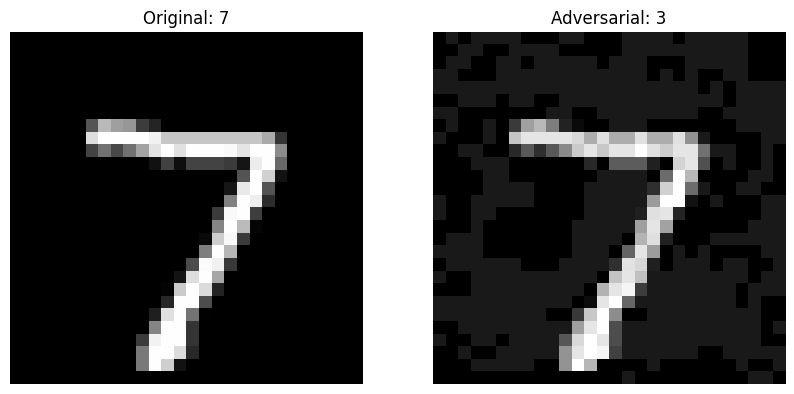

In [15]:
# Predict the class for both images
original_pred = np.argmax(model.predict(original_image.reshape(1, 28, 28)))
adversarial_pred = np.argmax(model.predict(adversarial_image.reshape(1, 28, 28)))
# Plot the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap="gray")
plt.title(f"Original: {original_pred}")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(adversarial_image, cmap="gray")
plt.title(f"Adversarial: {adversarial_pred}")
plt.axis("off")
plt.show()